In [14]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import time

from core import qlearning as q
from core import prices as pr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Variation du $\alpha$:

Je trouve les résultats assez aléatoires

Intuition : 

In [20]:
start = time.time()
aggregated_agents = []
for alpha in [0.1,0.2,0.3,0.4,0.5]:
    total_rewards = []

    for loop in range(3):
        print("Loop:", loop, "alpha:", alpha)
        agents = [q.Agent(alpha=alpha) for _ in range(2)]
        env = q.Env()

        temps = []
        rewards = []
        epsilon = []
        prices = []

        # Initialisation des prix p0 (on va le faire directement dans chaque agent)
        for agent in agents:
            agent.p = np.random.choice(agent.A)

        # Initialisation de l'état
        s_t = env([agent.p for agent in agents])[1]
        for agent in agents:
            agent.s_t = s_t

        s_ind = agents[0].find_index(agents[0].s_t)
        for agent in agents:
            agent.s_ind = s_ind

        # Phase itérative
        for t in range(1000):
            # Actions et état t+1
            for agent in agents:
                agent.a_ind = agent.get_next_action()

            s_t1 = env([agent.A[agent.a_ind] for agent in agents])[1]
            for agent in agents:
                agent.s_t1 = s_t1

            s_ind1 = agents[0].find_index(agents[0].s_t1)
            for agent in agents:
                agent.s_ind1 = s_ind1

            temps.append(t)
            ret = env(s_t1)
            quant, price, cost = ret

            re = ret[0]*ret[1]-ret[0]*ret[2]
            rewards.append(re)
            epsilon_values = [agent.epsilon for agent in agents]
            epsilon.append(epsilon_values)
            prices.append([agent.p for agent in agents])

            for i, agent in enumerate(agents):
                agent.updateQ(q=quant[i], p=price[i], c=cost[i], t=t)

        total_rewards.append(rewards)

    aggregated_agents.append(np.array(total_rewards).mean(axis=0))
end = time.time()

print(aggregated_agents)
print(end-start)

Loop: 0 alpha: 0.1
Loop: 1 alpha: 0.1
Loop: 2 alpha: 0.1
Loop: 0 alpha: 0.2
Loop: 1 alpha: 0.2
Loop: 2 alpha: 0.2
Loop: 0 alpha: 0.3
Loop: 1 alpha: 0.3
Loop: 2 alpha: 0.3
Loop: 0 alpha: 0.4
Loop: 1 alpha: 0.4
Loop: 2 alpha: 0.4
Loop: 0 alpha: 0.5
Loop: 1 alpha: 0.5
Loop: 2 alpha: 0.5
[array([[0.29761546, 0.2571914 ],
       [0.26937607, 0.21766961],
       [0.23625552, 0.28038577],
       ...,
       [0.23126012, 0.32141041],
       [0.30533245, 0.24408246],
       [0.28693311, 0.29922193]]), array([[0.24175831, 0.29767076],
       [0.3595191 , 0.27922033],
       [0.36967803, 0.2630995 ],
       ...,
       [0.33619526, 0.31123765],
       [0.2867348 , 0.23616662],
       [0.24253992, 0.3002055 ]]), array([[0.21246066, 0.27224165],
       [0.30753462, 0.26591547],
       [0.28207539, 0.28358753],
       ...,
       [0.3540498 , 0.2323184 ],
       [0.27032282, 0.24117431],
       [0.31507275, 0.27513717]]), array([[0.2561055 , 0.36044533],
       [0.26967115, 0.27070606],
       [0.20

In [21]:
aggregated_agents[0][:,1]

array([0.2571914 , 0.21766961, 0.28038577, 0.20880906, 0.33313159,
       0.325811  , 0.32442118, 0.29627942, 0.26147877, 0.28072987,
       0.26119659, 0.30161836, 0.31268016, 0.29148608, 0.33310314,
       0.25986355, 0.22792432, 0.23865658, 0.28415822, 0.22983588,
       0.26549045, 0.32768478, 0.29791401, 0.19485629, 0.3743467 ,
       0.30195939, 0.29181888, 0.33977338, 0.27114197, 0.25333773,
       0.25787769, 0.29527009, 0.19401734, 0.25447997, 0.2542492 ,
       0.22739958, 0.3488637 , 0.36368602, 0.26565765, 0.25286112,
       0.38123261, 0.26401056, 0.36067579, 0.36650444, 0.28719089,
       0.2023663 , 0.29884553, 0.32631449, 0.25206863, 0.2561252 ,
       0.28004886, 0.27967169, 0.34100083, 0.23297789, 0.2529114 ,
       0.28144247, 0.25135318, 0.25458388, 0.27499004, 0.19853296,
       0.28623022, 0.29826413, 0.37104006, 0.18461017, 0.25397513,
       0.28203275, 0.21160763, 0.23411116, 0.26659713, 0.2149417 ,
       0.27720785, 0.2925696 , 0.239066  , 0.24711327, 0.25347

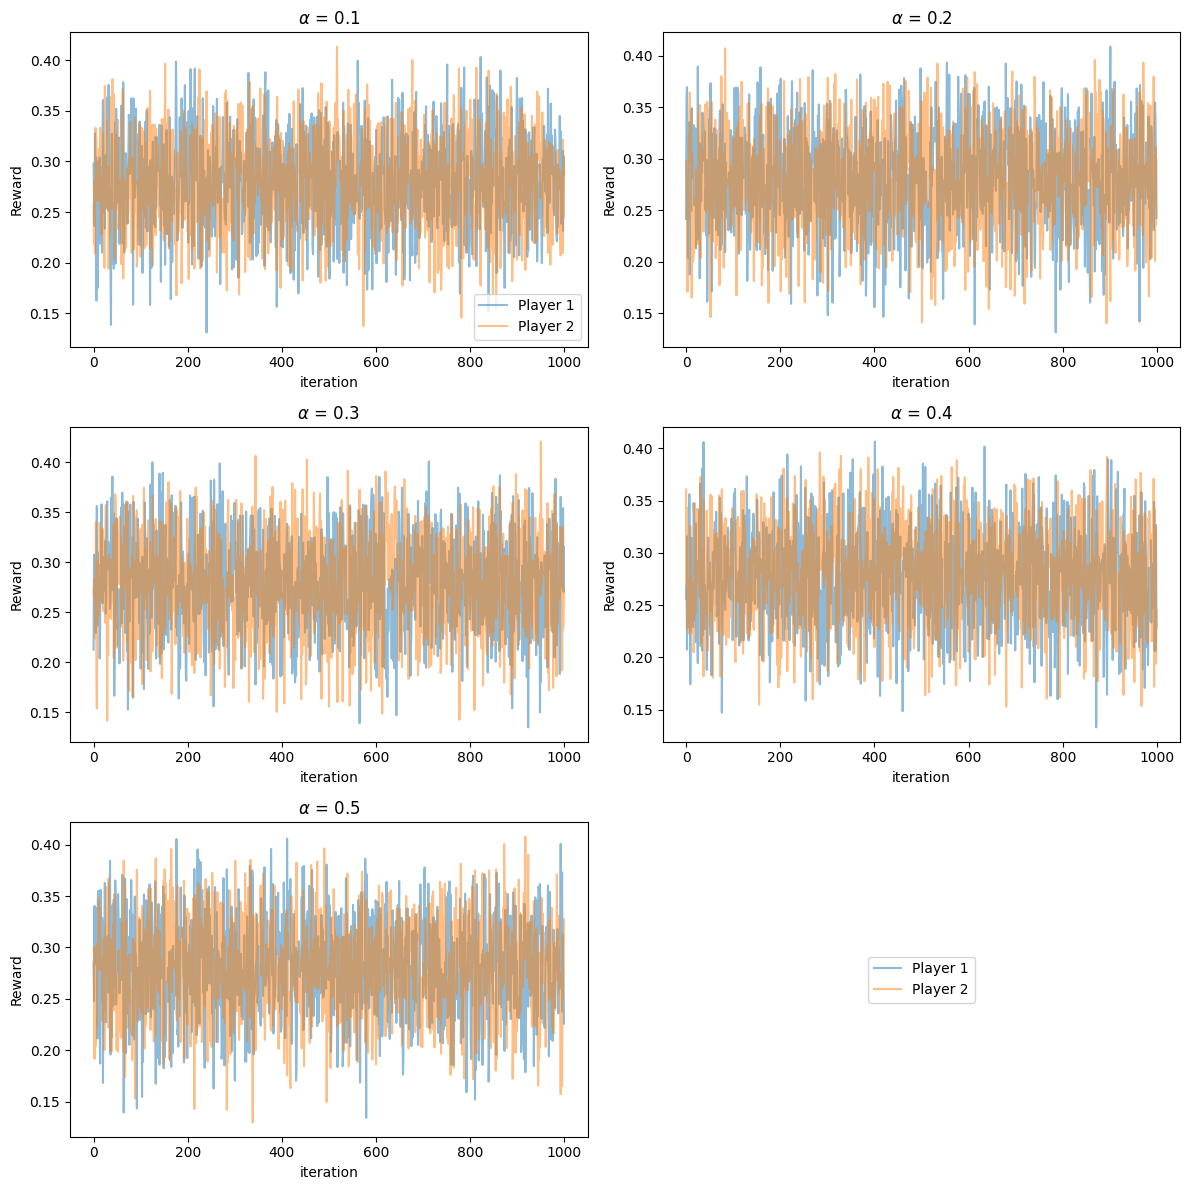

In [22]:
num_players = 2
num_graphs = len(aggregated_agents)
alpha = [0.1, 0.2, 0.3, 0.4, 0.5]

# Create a figure with a 3x2 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

# Flatten the axes array to iterate over the subplots
axes = axes.flatten()

# Loop to iterate through the periods and subplots
for graph_num in range(num_graphs):
    ax = axes[graph_num]
    num_players = len(aggregated_agents[graph_num][0])
    # Plot curves for each player in the subplot
    for player in range(num_players):
        ax.plot(aggregated_agents[graph_num][:, player], alpha=0.5, label=f'Player {player + 1}')
    
    # Set the title of the subplot with the corresponding period
    ax.set_title(f'$\\alpha$ = {alpha[graph_num]}')
    
    # Set the labels of the subplot
    ax.set_xlabel('iteration')
    ax.set_ylabel('Reward')

    # Add a legend to the first subplot
    if graph_num == 0:
        ax.legend()

# Remove any unused subplots
if num_graphs < 5:
    for i in range(num_graphs, 5):
        fig.delaxes(axes[i])

# Create a legend in the last subplot
legend_ax = axes[-1]
legend_ax.axis('off')

# Get the legend handles and labels from the first subplot
handles, labels = axes[0].get_legend_handles_labels()

# Create the legend in the last subplot
legend_ax.legend(handles, labels, loc='center')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

In [23]:
prices = pr.PriceOptimizer()
collusion_profit, collusion_prices = prices.CollusionPrice()
nash_profit, nash_prices = prices.NashPrice()
RN = nash_profit
RC = collusion_profit
    
Rmean = np.zeros((len(aggregated_agents), 2))
DRmean = np.zeros((len(aggregated_agents), 2))   
    
for i in range (len(aggregated_agents)): 
    for j in range (2):
        Rmean[i][j] = aggregated_agents[i][-100:,j].mean()
        DRmean[i][j] = (Rmean[i][j] - RN)/(RC - RN) 

print(DRmean)

[[0.53058841 0.49384176]
 [0.54594948 0.44332632]
 [0.46020895 0.53136829]
 [0.45431095 0.4681452 ]
 [0.47923496 0.5032133 ]]


[0.51221509 0.4946379  0.49578862 0.46122808 0.49122413]


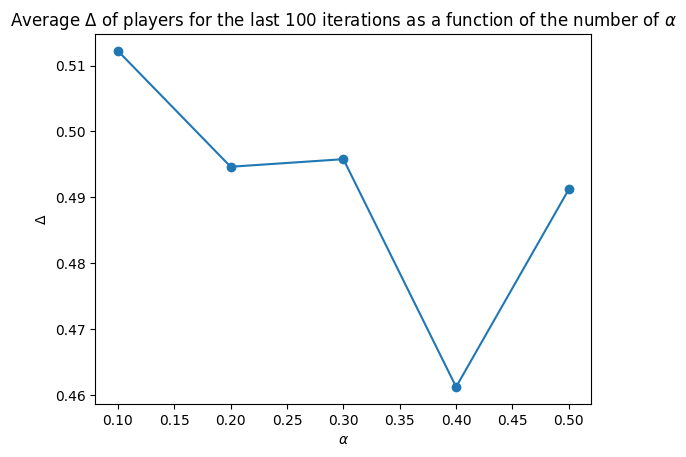

In [24]:
av = np.mean(DRmean, axis=1)
print(av)
plt.plot(alpha,av, linestyle='-', marker='o')
plt.xlabel('$\\alpha$')
plt.ylabel('$\\Delta$')
plt.title('Average $\\Delta$ of players for the last 100 iterations as a function of the number of $\\alpha$')
plt.show()